In [83]:
import random, numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

In [84]:
alphap = 2
probp = 0.75
expon = 2 * alphap - 1

In [85]:
ensemble_size = 500*1

time_iteration = 1000*100
min_iteration = 1000*10

# number_of_points = 21

iteration_step = 5000

## Directory

In [87]:
# dir_data = "../../data/alpha{}/".format(alphap)
# dir_fig  ="../../figures/alpha{}/".format(alphap)


# ## While testing
# dir_data = "../../data/temp/alpha{}/".format(alphap)
# dir_fig  ="../../figures/temp/alpha{}/".format(alphap)

# # create directory if it does not exists
# for dir_name in [dir_data, dir_fig]:
#     if not os.path.isdir(dir_name):
#         os.mkdir(dir_name)
#         print("directory ", dir_name, " is created")
#     else:
#         print("directory ", dir_name, " exists")
#     pass

# ### Filename
# filename = "fractal_dim_alpha_{}_p_{}".format(alphap, int(probp*100))
# out_data_filename = dir_data +filename
# print(out_data_filename)

## Functions

In [67]:
def betadist(alpha):
    """gives a random number from beta distribution"""
    return random.betavariate(alpha,alpha)

In [68]:
def decision(probability):
    """
    decides with a given probability whether to keep the right part
    """
    if float(probability) > random.random():
        return True
    else: 
        return False

In [69]:
def splitting(segment):
    """
    splits a given segment. left and right are endpoints of the segment
    returns : 
        xL -> length of the left segment
        xR -> length of the right segment
        flag -> keeping the right segment
        xLp, xRp -> probability(unnormalized) for being selected
        change -> change of normalization const
    """
    xL = segment * betadist(alphap)
    xR = segment - xL
    flag = decision(probp)
    xLp = xL**expon
    xRp = xR**expon
    change = xLp + xRp - segment**expon
    return xL, xR, flag, xLp, xRp, change

In [70]:
# def pickindex(frag_prob, frag_prob_sum):
#     """
#     picks up a segment to be subsequently split
#     """
#     r = random.uniform(0, frag_prob_sum)
#     sum_ = 0
#     for index in range(len(frag_prob)):
#         sum_ += frag_prob[index]
#         if sum_ < r:
#             continue
#         else:
#             return index

In [71]:
def pickindex(frag_prob, frac_sum):
    """
    picks up a segment to be subsequently split
    """
    r = random.uniform(0,1)
    
    if r <= frac_sum:
        sum_ = 0
        for index in range(len(frag_prob)):
            sum_ += frag_prob[index]
            if sum_ < r:
                continue
            else:
                return index

In [72]:
def number_length(segment_lengths,flags):
    
    N = 0
    M = 0

    for i in range(len(flags)):
        if flags[i]:
            N += 1
            M += segment_lengths[i]
            pass
        pass
    return N, M

In [73]:
def realization_value(total_iteration, min_iteration, iteration_step):
    
    lengths = [1.]
    flags = [True]
    frag_prob = [1.] # raw probability, not normalized
    #frag_prob_sum = 1.0 # normalization const
    frac_sum = 1.0

    iteration_list = list(range(min_iteration, total_iteration + 1, iteration_step))
    N_realization = []
    M_realization = []
    
    for i in range(total_iteration + 1):
        
        #index = pickindex(frag_prob, frag_prob_sum)
        index = pickindex(frag_prob, frac_sum)
        
        if index != None and flags[index] == True:

            xL, xR, flag, xLp, xRp, change = splitting(lengths[index])
            
            lengths[index] = xL
            lengths.append(xR)
            flags.append(flag)
            frag_prob[index] = xLp 
            frag_prob.append(xRp)
            #frag_prob_sum += change
            frac_sum += change
            pass
        
        if i+1 in iteration_list:
            N, M = number_length(lengths,flags)
            N_realization.append(N)
            M_realization.append(M)
        pass 
    
    N_list = np.array(N_realization)
    M_list = np.array(M_realization)
    
    return N_list, M_list

In [74]:
# import time
# t1 = time.time()
# realization_value(100_000, 10_000, 10_000)
# t2 = time.time()
# run_time = t2 - t1
# print("run_time is ", run_time, " sec")

In [75]:
def ensemble_average(total_iteration, min_iteration, iteration_step, ensemble_size):

    data_points = int ((total_iteration - min_iteration)/iteration_step + 1)
    N_ensemble = np.zeros(data_points)
    M_ensemble = np.zeros(data_points)
    
    for i in range(ensemble_size):
        if i % 1000 == 0:
            print("working with realization ",i)
        N_list, M_list = realization_value(total_iteration, min_iteration, iteration_step)
        N_ensemble += N_list
        M_ensemble += M_list
        pass
    
    N_average = N_ensemble/ensemble_size
    M_average = M_ensemble/ensemble_size
    
    return N_average, M_average

working with realization  0
(19,)
0.7754089119687588


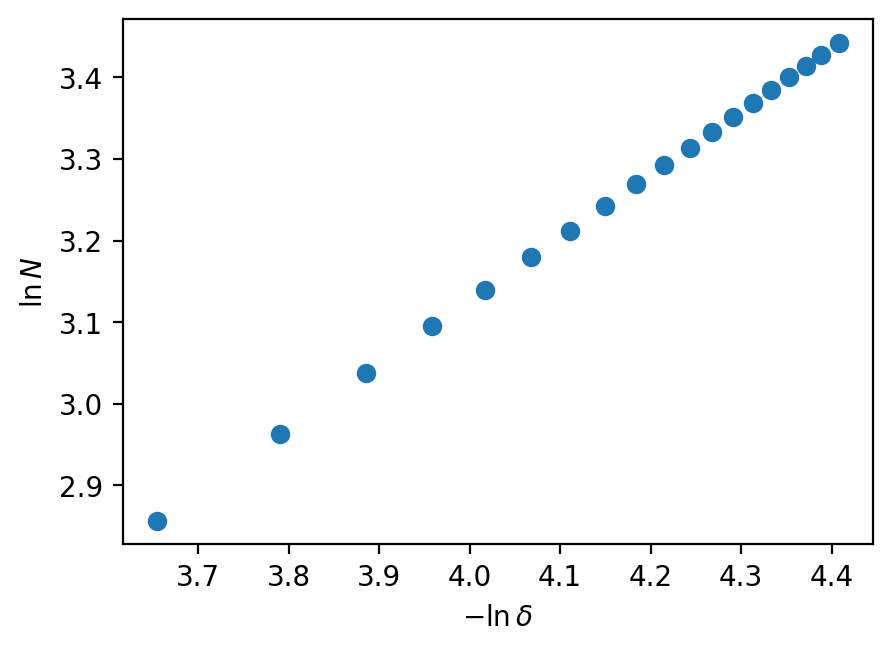

In [76]:
fig, axes = plt.subplots(1,1,figsize = (5,3.5),dpi = 200)

N1_average, M1_average = ensemble_average(time_iteration, min_iteration, iteration_step, ensemble_size)
print(N1_average.shape)
N1_log = np.log(N1_average)
minus_delta1_log = N1_log - np.log(M1_average)
slope, intercept = np.polyfit(minus_delta1_log, N1_log, 1)
print(slope)
plt.plot(minus_delta1_log, N1_log, "o")
plt.xlabel(r"$-\ln\,\delta$")
plt.ylabel(r"$\ln\,N$")
axes.set_position([0.15,0.15,0.75,0.75])

In [77]:
N1_average.shape

(19,)

In [78]:
M1_average

array([0.45051091, 0.43727194, 0.42849451, 0.42159998, 0.41601029,
       0.41104093, 0.40675591, 0.40334366, 0.40049281, 0.39726451,
       0.39468655, 0.39266395, 0.39084863, 0.38891255, 0.38726656,
       0.3857592 , 0.38403472, 0.38243292, 0.38058024])

## Write data to file

In [79]:
import json

header = dict()
header['alpha'] = alphap
header['probability'] = probp
header['ensemble_size']=ensemble_size
header['total_time_iteraion']=time_iteration
header['min_time_iteraion']=min_iteration
header['cols'] = ["t", "N", "M"]

time_col = np.arange(min_iteration, time_iteration+1, iteration_step)

header_str = json.dumps(header)
print(header_str)
print(out_data_filename)
# np.savetxt(out_data_filename, np.c_[time_col, N1_average, M1_average], header=header_str)

{"alpha": 2, "probability": 0.75, "ensemble_size": 500, "total_time_iteraion": 100000, "min_time_iteraion": 10000, "cols": ["t", "N", "M"]}


NameError: name 'out_data_filename' is not defined

### plot $-\ln \delta$ vs $\ln t$

In [80]:
def convert_to_plot(N1_average, M1_average):
    N1_log = np.log(N1_average)
    minus_delta1_log = N1_log - np.log(M1_average)
    slope, intercept = np.polyfit(minus_delta1_log, N1_log, 1)
    return minus_delta1_log, N1_log, slope, intercept

(19,)
(19,)


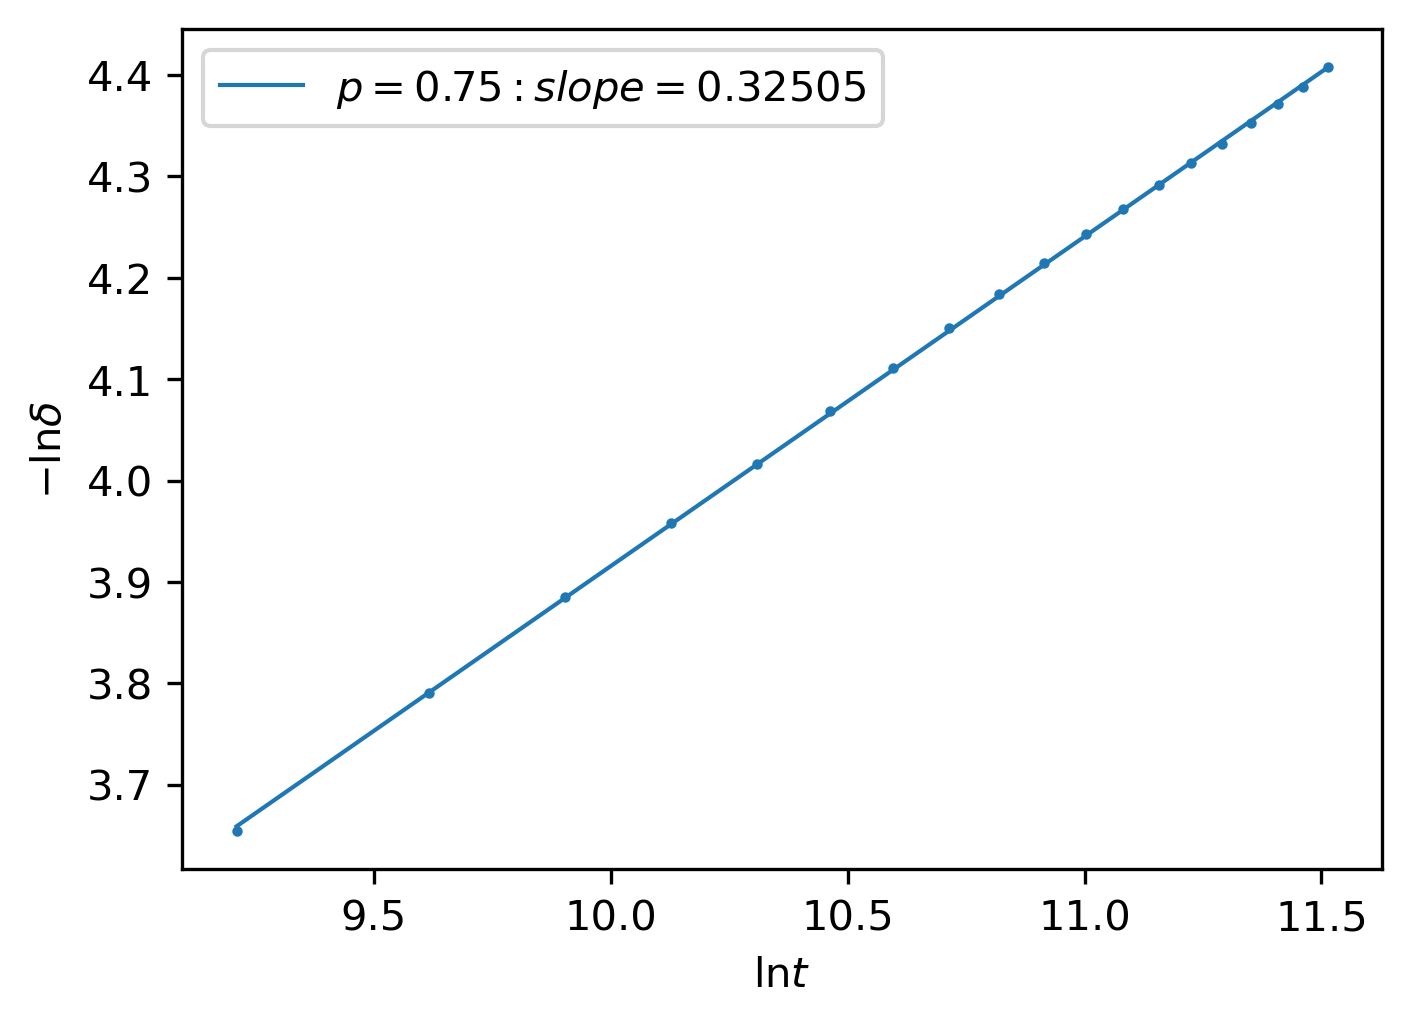

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), dpi=300)
colors = ['tab:blue', 'tab:orange', 'tab:green']

i = 0

tt = np.arange(min_iteration, time_iteration+1, iteration_step)
print(tt.shape)
t, N, M =tt, N1_average, M1_average
print(N1_average.shape)
y, yyy, slope, intercept = convert_to_plot(N, M)
log_t = np.log(t)


regress = stats.linregress(log_t, y)
plt.plot(log_t, y, 'o', color=colors[i], markersize=1.5)
yyyyy = log_t*regress[0] + regress[1]
plt.plot(log_t, yyyyy, label=r"$p={:.2f}: slope={:.5f}$".format(probp, regress[0]),  color=colors[i], linewidth=1)
i += 1

# plt.legend(loc='best', bbox_to_anchor=(0.5, 0.05, 0.5, 0.5))
plt.legend(loc=2)
plt.ylabel(r"$-\ln \delta$")
plt.xlabel(r"$\ln t$")
# plt.ylim([0.5, 3])
ax.set_position([0.15, 0.15, 0.8, 0.8])
# print(fig_filename)
# plt.savefig(fig_filename